In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE # wrapper method pour choisir les features
from sklearn.linear_model import RidgeClassifierCV

from sklearn.preprocessing import OneHotEncoder
import pickle

import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
#from mlflow.models.signature import infer_signature

#Export new_df_test => sera utilisé pour la prédiction du modele avec fastapi


Importation des fichiers

In [30]:
df_train= pd.read_feather("../../datasets/train_2.feather")
df_test = pd.read_feather("../../datasets/test_2.feather")
df_train.drop(df_train[df_train['CODE_GENDER']=='XNA'].index,axis=0, inplace = True)
#df_train.shape #confirmation de la suppression des 4 lignes

Remplacement des valeurs manquantes

In [31]:
for col_na in df_train.isna().sum()[df_train.isna().sum() > 0 ].index: 
    print(col_na,df_train[col_na].dtype)
    if df_train[col_na].dtype =='object':
        print(col_na)
        df_train[col_na] = df_train[col_na].fillna(df_train[col_na].mode().values[0]) # var categ val mqte => mot le plus fréquent
    else :
        df_train[col_na] = df_train[col_na].fillna(df_train[col_na].median()) # val mqtes => mediane
df_train.isna().sum().sum()

AMT_ANNUITY float64
AMT_GOODS_PRICE float64
NAME_TYPE_SUITE object
NAME_TYPE_SUITE
CNT_FAM_MEMBERS float64
EXT_SOURCE_2 float64
EXT_SOURCE_3 float64
OBS_30_CNT_SOCIAL_CIRCLE float64
DEF_30_CNT_SOCIAL_CIRCLE float64
OBS_60_CNT_SOCIAL_CIRCLE float64
DEF_60_CNT_SOCIAL_CIRCLE float64
DAYS_LAST_PHONE_CHANGE float64
AMT_REQ_CREDIT_BUREAU_HOUR float64
AMT_REQ_CREDIT_BUREAU_DAY float64
AMT_REQ_CREDIT_BUREAU_WEEK float64
AMT_REQ_CREDIT_BUREAU_MON float64
AMT_REQ_CREDIT_BUREAU_QRT float64
AMT_REQ_CREDIT_BUREAU_YEAR float64


0

Separation du jdd

In [32]:
X_train,X_test,y_train,y_test = train_test_split(df_train.drop(['TARGET'], axis =1),
                                                 df_train['TARGET'],
                                                test_size=0.3,
                                                random_state=42)

Configuration des hyperparamètres

In [33]:
ar = X_train.select_dtypes('object').columns #nom des colonnes sous format objets

Nombre optimal de features avec RFE => recursive feature elimination

#https://machinelearningmastery.com/rfe-feature-selection-in-python/
rfe_selector = RFE(estimator = RidgeClassifierCV(),n_features_to_select=70, step=10, verbose = 5)
rfe_selector

rfe_selector.fit(X_tr_scaled,y_train) #sur données mise à l'échelle
rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:,rfe_support].columns.to_list()
print(str(len(rfe_feature)),'selected features')

Pipeline

ct = ColumnTransformer([('one-hot-encoder', OneHotEncoder(), ar)], remainder='passthrough')
ct.fit(df_train) #https://vitalflux.com/one-hot-encoding-concepts-python-code-examples/#What_is_One-Hot_Encoding pour le résultat

In [ ]:
ar_val = []
for index,ar_values in enumerate(ar) :
    ar_val.append([i for i in (X_train[ar_values].value_counts().index.values)])

In [86]:
#Leave-One-Out cross-validation chaque observation est testé si cv = none mais recquiert beaucoup de temps, meilleur cv = 10 
#ColumnTransformer rajouté sinon onehot fait pour toutes les colonnes
pipel= Pipeline(steps=[('categ_scaler', ColumnTransformer([('one-hot-encoder', OneHotEncoder(handle_unknown="error", categories = ar_val), ar.values)],remainder=StandardScaler(with_mean=True), verbose = True)),
                       ('rfe',   RFE(estimator = RidgeClassifierCV(class_weight='balanced',cv=3,alphas=(0.1,1,10,50),scoring = 'recall'),
                                 step=10,
                                 verbose = 5
                                    )
                       )
                    ])
#('model',RidgeClassifierCV(class_weight='balanced', alphas=(0.1,1,10,100,1000))) cv = 3 sinon 10 trop long

In [ ]:
ar = X_train.select_dtypes('object').columns #nom des colonnes sous format objets

NameError: name 'X_train' is not defined

categories par colonne

In [89]:
#pipel[1].estimator_.coef_ # pour avoir feature importance
#"Found unknown categories [7] in column 5 during transform", while running with n_jobs=1
param_grid =  {'rfe__n_features_to_select':[0.7]} #grid params with __ (0.3,3,30) #,0.8,0.9
search = GridSearchCV(pipel, param_grid, n_jobs=1, scoring = 'recall', verbose = 3) 
search.fit(X_train.drop(['SK_ID_CURR'], axis =1), y_train) # 21 min pour un parametre dans le gridsearch et 4 parametres dans ridgeclassifier 

[ColumnTransformer]  (1 of 2) Processing one-hot-encoder, total=   2.2s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   1.2s
Fitting estimator with 164 features.
Fitting estimator with 154 features.
Fitting estimator with 144 features.
Fitting estimator with 134 features.
Fitting estimator with 124 features.
[ColumnTransformer]  (1 of 2) Processing one-hot-encoder, total=   1.9s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   1.1s
Fitting estimator with 164 features.
Fitting estimator with 154 features.
Fitting estimator with 144 features.
Fitting estimator with 134 features.
Fitting estimator with 124 features.
[ColumnTransformer]  (1 of 2) Processing one-hot-encoder, total=   1.7s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   1.1s
Fitting estimator with 164 features.
Fitting estimator with 154 features.
Fitting estimator with 144 features.
Fitting estimator with 134 features.
Fitting estimator with 124 features.
[ColumnTransform

GridSearchCV(estimator=Pipeline(steps=[('categ_scaler',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('one-hot-encoder',
                                                                         OneHotEncoder(categories=[['Cash '
                                                                                                    'loans',
                                                                                                    'Revolving '
                                                                                                    'loans'],
                                                                                                   ['F',
                                                                                                    'M'],
                                                                                                   ['N',
                                                                                                    'Y'],
                                                                                                   ['Y',
                                                                                                    'N'],
                                                                                                   ['Unaccompanied',
                                                                                                    'Family',
                                                                                                    'Spouse, '
                                                                                                    'partner',
                                                                                                    'Children',
                                                                                                    'Other_B',
                                                                                                    'Other_A',
                                                                                                    'Group '
                                                                                                    'of '
                                                                                                    'people'],
                                                                                                   ['Working',
                                                                                                    'Commercial '
                                                                                                    'assoc...
       'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'], dtype=object))],
                                                          verbose=True)),
                                       ('rfe',
                                        RFE(estimator=RidgeClassifierCV(alphas=(0.1,
                                                                                1,
                                                                                10,
                                                                                50),
                                                                        class_weight='balanced',
                                                                        cv=3,
                                                                        scoring='recall'),
                                            step=10, verbose=5))]),
             n_jobs=1, param_grid={'rfe__n_features_to_select': [0.7]},
             scoring='recall')

In [122]:
search.best_estimator_.steps[1][1].estimator

RidgeClassifierCV(alphas=(0.1, 1, 10, 50), class_weight='balanced', cv=3,
                  scoring='recall')

In [126]:
search.best_estimator_.named_steps

{'categ_scaler': ColumnTransformer(remainder=StandardScaler(),
                   transformers=[('one-hot-encoder',
                                  OneHotEncoder(categories=[['Cash loans',
                                                             'Revolving loans'],
                                                            ['F', 'M'],
                                                            ['N', 'Y'],
                                                            ['Y', 'N'],
                                                            ['Unaccompanied',
                                                             'Family',
                                                             'Spouse, partner',
                                                             'Children',
                                                             'Other_B',
                                                             'Other_A',
                                                             'Grou

In [132]:
search.best_estimator_[1].estimator.__dir__()

['alphas',
 'fit_intercept',
 'scoring',
 'cv',
 'gcv_mode',
 'store_cv_values',
 'alpha_per_target',
 'class_weight',
 '__module__',
 '__annotations__',
 '__doc__',
 '_parameter_constraints',
 'param',
 '__init__',
 'fit',
 '_more_tags',
 '__abstractmethods__',
 '_abc_impl',
 '_prepare_data',
 'predict',
 'classes_',
 'decision_function',
 '_predict_proba_lr',
 '_estimator_type',
 'score',
 '__dict__',
 '__weakref__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__',
 '_decision_function',
 '_set_intercept',
 '_get_param_names',
 'get_params',
 'set_params',
 '__getstate__',
 '__setstate__',
 '_get_tags',
 '_check_n_features',
 '_check_feature_names',
 '_validate_data',
 '_validate_params',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mim

In [174]:
search.best_estimator_.steps[1][1].estimator_.coef_

array([[-8.23943652e-02,  8.23943651e-02,  5.62116781e-02,
        -5.62116781e-02, -3.79727739e-02,  5.47800436e-02,
         4.09120540e-02,  4.10371357e-01,  3.66271873e-01,
        -1.27737959e+00,  3.60426989e-01, -2.58802053e-01,
        -2.01563566e-01,  2.27395839e-02,  5.77935407e-01,
         1.51291170e-01,  4.30709365e-02,  2.22971702e-01,
        -3.51445466e-01, -6.99003420e-04,  4.74872208e-02,
         7.01240401e-02,  6.51966109e-02, -2.54697953e-02,
         5.94149554e-02,  5.15010788e-02, -5.67092769e-02,
        -1.65821961e-02, -3.47124689e-02, -2.85216929e-02,
        -4.71231278e-02,  2.13807299e-01, -1.95299258e+00,
         2.38776162e-01,  1.57206431e-01,  1.29754981e-01,
         1.76260211e-01,  1.24010116e-01,  9.11443078e-02,
         2.05525659e-01,  1.60418161e-01,  2.77705528e-01,
         1.58644981e-01,  2.23195303e-01,  2.58884224e-01,
         2.02331048e-01,  2.30115212e-01,  1.55594015e-01,
         2.15981400e-01,  1.01002904e-01,  2.59523509e-0

In [90]:
search.cv_results_

{'mean_fit_time': array([203.99719629]),
 'std_fit_time': array([13.04841595]),
 'mean_score_time': array([1.39802284]),
 'std_score_time': array([0.12961348]),
 'param_rfe__n_features_to_select': masked_array(data=[0.7],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'rfe__n_features_to_select': 0.7}],
 'split0_test_score': array([0.66484465]),
 'split1_test_score': array([0.6551625]),
 'split2_test_score': array([0.66637906]),
 'split3_test_score': array([0.67788323]),
 'split4_test_score': array([0.6769275]),
 'mean_test_score': array([0.66823939]),
 'std_test_score': array([0.00841994]),
 'rank_test_score': array([1])}

In [93]:
mlflow.get_tracking_uri()

'http://127.0.0.1:5000'

Mlflow

In [92]:
mlflow.set_tracking_uri('http://127.0.0.1:5000') # changé de 5000

In [95]:
search.cv_results_

{'mean_fit_time': array([203.99719629]),
 'std_fit_time': array([13.04841595]),
 'mean_score_time': array([1.39802284]),
 'std_score_time': array([0.12961348]),
 'param_rfe__n_features_to_select': masked_array(data=[0.7],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'rfe__n_features_to_select': 0.7}],
 'split0_test_score': array([0.66484465]),
 'split1_test_score': array([0.6551625]),
 'split2_test_score': array([0.66637906]),
 'split3_test_score': array([0.67788323]),
 'split4_test_score': array([0.6769275]),
 'mean_test_score': array([0.66823939]),
 'std_test_score': array([0.00841994]),
 'rank_test_score': array([1])}

In [104]:
mlflow.set_experiment("Pipeline + Gridsearch") #Set the given experiment as the active experiment. The experiment must either be specified by name via experiment_name 
for i in range(len(search.cv_results_['params'])): # search remplace log_reg
    run_index = i
    cv_results = search.cv_results_
    with mlflow.start_run(run_name=str(run_index)) as run:  
            mlflow.log_param("folds", search.cv)
            print("Logging parameters")
            params = list(search.param_grid.keys())
            for param in params:
                mlflow.log_param(param, cv_results["param_%s" % param][run_index])
            print("Logging metrics")
            for score_name in [score for score in cv_results if "mean_test" in score]:
                mlflow.log_metric(score_name, cv_results[score_name][run_index])
                mlflow.log_metric(score_name.replace("mean","std"), cv_results[score_name.replace("mean","std")][run_index])
            print("Logging model")        
            mlflow.sklearn.log_model(search.best_estimator_, 'Ridge_classifier_CV')#cv_results[score_name.replace("mean","std")][run_index]

Logging parameters
Logging metrics
Logging model


In [175]:
pickle_out = open("pipel_3.pkl","wb") # avec one hot encoder scaler et rfe , prochaine version avec 0.7,0.8,0.9
pickle.dump(search.best_estimator_,pickle_out)
pickle_out.close()

Import du modele qu'on a exporté pour tester

In [181]:
pd.DataFrame(X_test.iloc[0,:]).transpose()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
232927,369780,Cash loans,F,N,Y,2,72000.0,198666.0,15696.0,175500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [182]:
pickle_in = open("pipel_3.pkl","rb") #notre pipeline importé
classifier_test=pickle.load(pickle_in) #chargé dans une variable
classifier_test.predict(pd.DataFrame(X_test.iloc[0,:]).transpose())#X_test.loc[0,:] pd.DataFrame(X_test.iloc[0,:]).transpose()

array([0], dtype=int64)

Feature importance

#au lieu d'avoir une series permet d'avoir un format dataframe comme attendue par standardscaler
pd.DataFrame(X_train.iloc[0,:]).transpose()

tuto à suivre pour améliorer bokeh

https://trenton3983.github.io/files/projects/2020-03-15_interactive_data_visualization_with_bokeh/2020-03-15_interactive_data_visualization_with_bokeh.html

In [ ]:
# sorting the bars means sorting the range factors
sorted_fruits = sorted(cols, key=lambda x: feat_i[cols.to_list().index(x)])
#x_range=sorted_fruits

p = figure(x_range=sorted_fruits, height=350, title="Feature_importance",
           tools='pan,box_zoom,reset')

p.vbar(x=cols.values, top=feat_i, width=0.9)

p.xaxis.major_label_orientation = "vertical"
p.axis.major_label_standoff  = 5 # distance entre les labels x et la visualisation

#p.xgrid.grid_line_color = None
p.y_range.start = 0

show(p)

https://docs.bokeh.org/en/latest/docs/user_guide/plotting.html

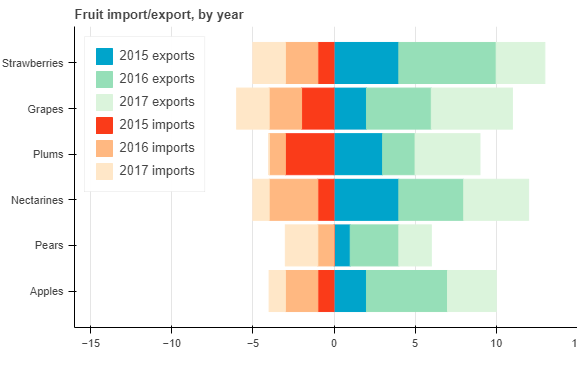